# Question #2:
Do employees have a statistically significant effect on order values? If so, does the employee's region have a statistically significant effect?

### Library and Data Import

In [220]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')
import sqlite3
from pandasql import sqldf
from importlib import reload
from itertools import combinations

#Pulling functions generated throughout the course of the module to assist with some of the testing.
import flatiron_stats as fs

#Setting significance level:
a = 0.05
reload(fs)

<module 'flatiron_stats' from 'C:\\Users\\Drew\\flatiron-ds-course\\Mod-3\\dsc-mod-3-project-online-ds-ft-090919\\flatiron_stats.py'>

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

### Hypothesis 1
H0: Different Employees have no statistically significant effect on order values.<br>
HA: Different Employees have a statistically significant effect on order values.<br>

### Hypothesis 2
H0: Employee Region has no statistically significant effect on order values.<br>
HA: Employee Region has a statistically significant effect on order values.<br>

### Gathering Data

In [50]:
query = """SELECT EmployeeID, Region, ROUND(AVG(ItemTotal), 2) as AvgTotal,
           MIN(ItemTotal) as MinTotal, MAX(ItemTotal) as MaxTotal, 
           COUNT(*) as TotalOrders
           FROM (SELECT e.Id as EmployeeID, e.Region, od.OrderID, 
                   SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) as ItemTotal
                   FROM Employee e
                   JOIN 'Order' o
                   ON o.EmployeeID = e.Id
                   JOIN OrderDetail od
                   ON o.Id = od.OrderID
                   GROUP BY 3)
           GROUP BY 1
           """
pd.read_sql(query, conn)

,EmployeeID,Region,AvgTotal,MinTotal,MaxTotal,TotalOrders
0,1,North America,1561.85,33.75,15810.000,123
1,2,North America,1734.77,40.00,16387.500,96
2,3,North America,1596.95,45.00,10952.845,127
3,4,North America,1492.89,18.40,11188.400,156
4,5,British Isles,1637.91,103.20,9210.900,42
5,6,British Isles,1103.18,48.00,4707.540,67
6,7,British Isles,1730.11,36.00,12615.050,72
7,8,North America,1219.83,36.00,4825.000,104
8,9,British Isles,1797.86,12.50,11380.000,43


Initial review indicates that there is some difference between employees, and potentially some difference between regions as well, however, there is a noticeable difference between the number of orders for North American sales reps as opposed to British Isles sales reps. 

It may be worth it to determine difference between sales reps of a given region, rather than all sales reps. I'll start by finding the answer to the second question (Does employee region have a statistically significant effect on order values?) and if that does prove to be the case, then I will test employees only against other reps of their own region to ensure the difference in the number of orders doesn't taint the testing.

In [73]:
query = """SELECT EmployeeID, Region, ROUND(AVG(OrderTotal), 2) as AvgTotal,
           MIN(OrderTotal) as MinTotal, MAX(OrderTotal) as MaxTotal, 
           COUNT(*) as TotalOrders
           FROM (SELECT e.Id as EmployeeID, e.Region, od.OrderID, 
                 SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) as OrderTotal
                 FROM Employee e
                 JOIN 'Order' o
                 ON o.EmployeeID = e.Id
                 JOIN OrderDetail od
                 ON o.Id = od.OrderID
                 GROUP BY 3)
           GROUP BY 2
           """
pd.read_sql(query, conn)

,EmployeeID,Region,AvgTotal,MinTotal,MaxTotal,TotalOrders
0,7,British Isles,1538.31,12.5,12615.05,224
1,2,North America,1520.15,18.4,16387.50,606


In [157]:
query = """SELECT e.Id as EmployeeID, e.Region, od.OrderID, 
            SUM(od.UnitPrice * od.Quantity * (1 - od.Discount)) as OrderTotal
            FROM Employee e
            JOIN 'Order' o
            ON o.EmployeeID = e.Id
            JOIN OrderDetail od
            ON o.Id = od.OrderID
            GROUP BY 3
           """
df = pd.read_sql(query, conn)
na_reps = df[df.Region == 'North America']
bi_reps = df[df.Region == 'British Isles']
bi_reps.describe()

,EmployeeID,OrderId,OrderTotal
count,224.000000,224.000000,224.000000
mean,6.709821,10665.075893,1538.311221
std,1.319292,236.639797,1892.265365
min,5.000000,10248.000000,12.500000
25%,6.000000,10482.250000,454.066250
50%,7.000000,10666.500000,868.650000
75%,7.000000,10869.250000,1896.087500
max,9.000000,11074.000000,12615.050000


### Visualizing the Data
Exploring the data visually to understand the order values of each region.

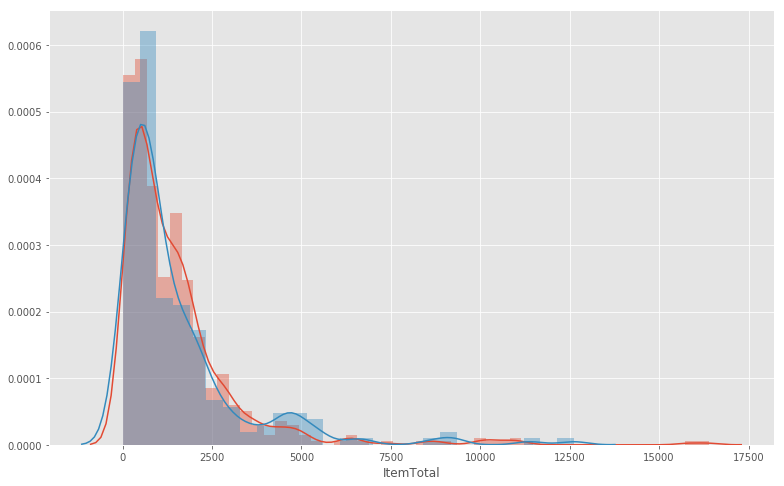

In [72]:
plt.figure(figsize = (13, 8))
sns.distplot(na_reps.OrderTotal)
sns.distplot(bi_reps.OrderTotal)

## Hypothesis 2 Testing
Since the visualizations and table show that there may not be much of a difference, we'll move on to testing to determine whether or not that difference is of a statistical significance. To answer this question, we will perform an Independent T-Test, however, in order to do that, we must first check a couple of assumptions with our data. 1: Our Distributions are Normal, and 2: Our Distributions' Variances are equal.

To restate, our hypothesis is: <br>
H0: Employee Region has no statistically significant effect on order values. <br>
HA: Employee Region has a statistically significant effect on order values.

### Normality
While there is a hint of normality to each distribution, they both have some degree of positive skew. To determine normality, we'll run KS (Kolmogorov-Smirnov) and Shapiro tests, using our significance value of 0.05.

In [106]:
for region in df.Region.unique():
    data = df[df['Region'] == region]['OrderTotal']
    mu = data.mean()
    std = data.std()
    stat, p = stats.kstest(data, 'norm', args = (mu, std))
    print(f"KS Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

KS Test for British Isles:
Test Statistic: 0.21002311670429863
P-Value: 3.8003005187192684e-09
Is Normal: False

KS Test for North America:
Test Statistic: 0.20580507395169545
P-Value: 0.0
Is Normal: False



In [108]:
for region in df.Region.unique():
    data = df[df['Region'] == region]['OrderTotal']
    mu = data.mean()
    std = data.std()
    stat, p = stats.shapiro(data)
    print(f"Shapiro Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

Shapiro Test for British Isles:
Test Statistic: 0.6888653039932251
P-Value: 4.148470715079689e-20
Is Normal: False

Shapiro Test for North America:
Test Statistic: 0.6509366631507874
P-Value: 2.3919232720310457e-33
Is Normal: False



Both tests indicate that neither of the distributions are normal. While a Welch's T-Test is doable with non-normal distributions, in order to better compare each region's effect size, we'll take a number of samples to gather a more normal distribution for each region based on the Central Limit Theorem.

### Sampling and Reviewing

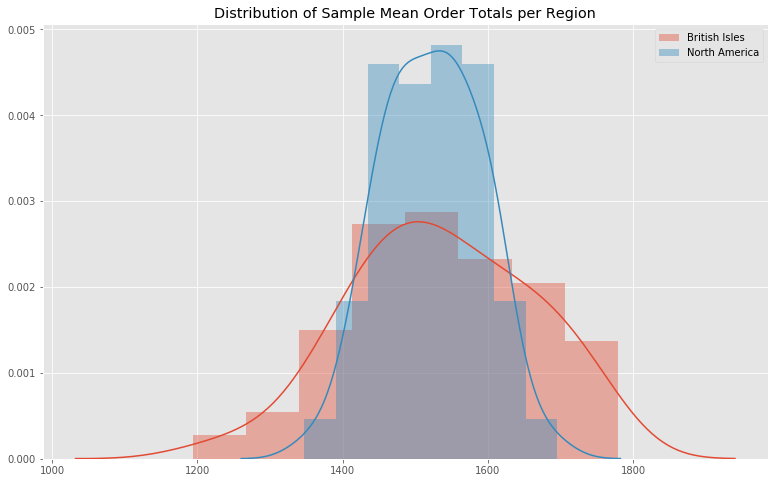

In [148]:
num_samples = 100
sample_size = 15
plt.figure(figsize = (13, 8))
samp_dict = {}
for region in df.Region.unique():
    data = df[df['Region'] == region]['OrderTotal']
    samp_means = []
    for n in range(num_samples):
        sample = np.random.choice(data, size = len(data), replace = True)
        samp_means.append(sample.mean())
    samp_dict[region] = np.array(samp_means)
    label = region
    sns.distplot(samp_means, label = label)
plt.title('Distribution of Sample Mean Order Totals per Region')
plt.legend()

In [149]:
for region in df.Region.unique():
    data = samp_dict[region]
    stat, p = stats.shapiro(data)
    print(f"Shapiro Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

Shapiro Test for British Isles:
Test Statistic: 0.9872788190841675
P-Value: 0.45664143562316895
Is Normal: True

Shapiro Test for North America:
Test Statistic: 0.9915814399719238
P-Value: 0.7901404500007629
Is Normal: True



Now that we've got samples that meet our normality assumption, we need to check their variances and determine whether or not they're equal.

### Equal Variance Testing

In [154]:
fs.test_equal_variances(samp_dict['North America'], samp_dict['British Isles'])

p = 4.9308195117839164e-08
Therefore the data do not have equal variances


False

As our variances are not equal, we'll go ahead and use a Welch's T-Test to determine the result of our hypothesis.

### Welch's T-Test

In [155]:
stats.ttest_ind(samp_dict['North America'], samp_dict['British Isles'], equal_var=False)

Ttest_indResult(statistic=-0.905203225202732, pvalue=0.36679097391077586)

With a P-Value higher than our significance level, we fail to reject our Null Hypothesis, and determine that there is no statistically significant difference in order value based on the sales employee's region. Returning to our first question, we'll check each employee against each other employee, regardless of region, to determine if some have a statistically significant difference in their order values.

## Hypothesis 1 Testing
As we have 9 separate values to test against each other, we'll start as before, by exploring the employee data to determine normality, and take sample distributions if necessary.

To restate our hypothesis for this section:<br>
H0: Different Employees have no statistically significant effect on order values.<br>
HA: Different Employees have a statistically significant effect on order values.

### Visualizations

Text(0.5, 0, 'Order Totals')

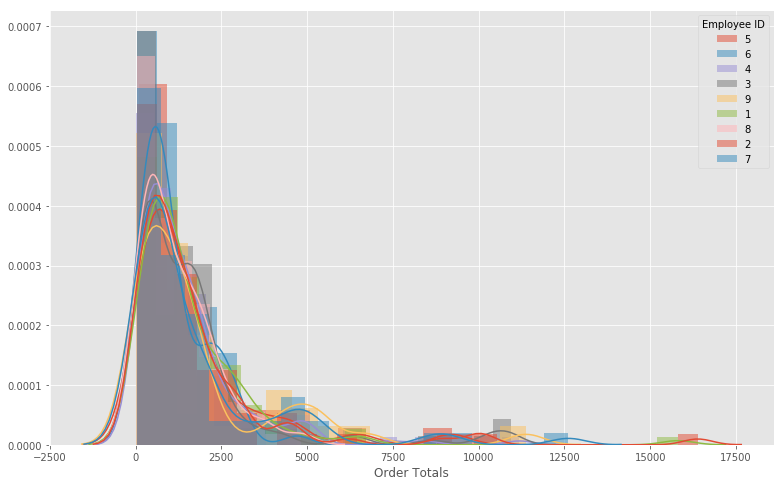

In [188]:
plt.figure(figsize = (13, 8))
for id in df.EmployeeID.unique():
    totals = df[df['EmployeeID'] == id]['OrderTotal']
    sns.distplot(totals, label = id, hist_kws = {'alpha': 0.5})
plt.legend(title = 'Employee ID')
plt.xlabel('Order Totals')

As with our regional data, there's a pretty hefty positive skew for every distribution. A quick Shapiro test should confirm lack of normality.

In [194]:
for id in df.EmployeeID.unique():
    totals = df[df['EmployeeID'] == id]['OrderTotal']
    print('\nShapiro Test for Employee ID: ' + str(id))
    fs.test_normality(totals)


Shapiro Test for Employee ID: 5
p = 1.8834317927485245e-07
Therefore the data is not normal

Shapiro Test for Employee ID: 6
p = 2.4758194285823265e-06
Therefore the data is not normal

Shapiro Test for Employee ID: 4
p = 1.959416117653192e-15
Therefore the data is not normal

Shapiro Test for Employee ID: 3
p = 1.3422417601414625e-16
Therefore the data is not normal

Shapiro Test for Employee ID: 9
p = 9.337541229115232e-08
Therefore the data is not normal

Shapiro Test for Employee ID: 1
p = 4.458695142865135e-16
Therefore the data is not normal

Shapiro Test for Employee ID: 8
p = 6.80455087831433e-08
Therefore the data is not normal

Shapiro Test for Employee ID: 2
p = 8.200300451156016e-15
Therefore the data is not normal

Shapiro Test for Employee ID: 7
p = 3.099489068181249e-11
Therefore the data is not normal


As expected. Let's grab a quick sample distribution for each employee to get a more normal dataset to work with.

### Sampling and Reviewing

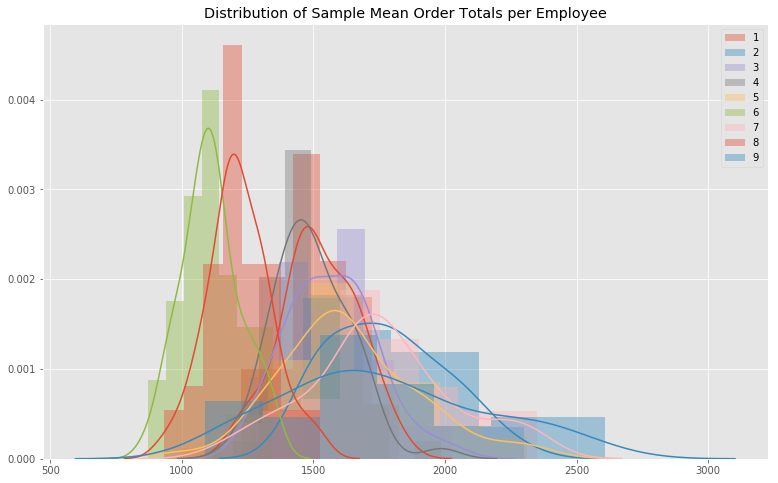

In [270]:
num_samples = 50
sample_size = 20
plt.figure(figsize = (13, 8))
samp_dict = {}
for id in sorted(df.EmployeeID.unique()):
    totals = df[df['EmployeeID'] == id]['OrderTotal']
    samp_means = []
    for n in range(num_samples):
        sample = np.random.choice(totals, size = len(totals), replace = True)
        samp_means.append(sample.mean())
    samp_dict[id] = np.array(samp_means)
    sns.distplot(samp_means, label = id)
plt.title('Distribution of Sample Mean Order Totals per Employee')
plt.legend()

In [271]:
for id in df.EmployeeID.unique():
    totals = samp_dict[id]
    print('\nShapiro Test for Employee ID: ' + str(id))
    fs.test_normality(totals)


Shapiro Test for Employee ID: 5
p = 0.2047765851020813
Therefore the data is normal

Shapiro Test for Employee ID: 6
p = 0.589250922203064
Therefore the data is normal

Shapiro Test for Employee ID: 4
p = 0.1262761950492859
Therefore the data is normal

Shapiro Test for Employee ID: 3
p = 0.5943106412887573
Therefore the data is normal

Shapiro Test for Employee ID: 9
p = 0.22703644633293152
Therefore the data is normal

Shapiro Test for Employee ID: 1
p = 0.6081439852714539
Therefore the data is normal

Shapiro Test for Employee ID: 8
p = 0.8218963146209717
Therefore the data is normal

Shapiro Test for Employee ID: 2
p = 0.10316203534603119
Therefore the data is normal

Shapiro Test for Employee ID: 7
p = 0.4006856679916382
Therefore the data is normal


In [272]:
samp_df = pd.DataFrame(columns = ['EmployeeID', 'SampleOrderTotalMean'])
samp_df['EmployeeID'] = samp_dict.keys()
samp_df['SampleOrderTotalMean'] = samp_dict.values()
samp_df = pd.concat([pd.DataFrame(dict(zip(samp_df.columns, samp_df.ix[i]))) for i in range(len(samp_df))])

With normal datasets, we can now move into our actual hypothesis testing with ANOVA and Tukey testing. We'll start with ANOVA, to determine overall whether or not there's a statistically significant difference amongst employees, and then move into Tukey to compare each set of employees individually.

### ANOVA

In [273]:
formula = "SampleOrderTotalMean ~ C(EmployeeID)"
lm = smf.ols(formula, samp_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df          F        PR(>F)
C(EmployeeID)  2.272931e+07    8.0  58.158423  2.657291e-64
Residual       2.154380e+07  441.0        NaN           NaN


With a P-Value significantly lower than our Alpha set above, we can reject our Null Hypothesis and say that there does appear to be a statistically significant difference in order total based on the sales rep. To figure out which pairs of employees have the largest difference, we'll run a Tukey Test.

### Tukey Test

In [274]:
tk = smc.MultiComparison(samp_df['SampleOrderTotalMean'], samp_df['EmployeeID'])
result = tk.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  1      2     255.8071  118.0088  393.6054  True 
  1      3     46.0252   -91.7731  183.8234 False 
  1      4     -25.1835 -162.9818  112.6148 False 
  1      5     111.6359  -26.1624  249.4342 False 
  1      6     -410.688 -548.4863 -272.8897  True 
  1      7     232.5826  94.7843   370.3809  True 
  1      8    -303.9119 -441.7102 -166.1136  True 
  1      9     247.8969  110.0986  385.6952  True 
  2      3    -209.7819 -347.5802  -71.9837  True 
  2      4    -280.9906 -418.7889 -143.1923  True 
  2      5    -144.1712 -281.9695  -6.3729   True 
  2      6    -666.4951 -804.2934 -528.6968  True 
  2      7     -23.2245 -161.0228  114.5738 False 
  2      8     -559.719 -697.5173 -421.9208  True 
  2      9     -7.9102  -145.7085  129.888  False 
  3      4     -71.2087 -209.0069  66.5896  False 
  3      5     65.6107   -72.18

Based on the results of the Tukey test as well as the visualizations from earlier, it appears that the employee with the ID 6 has significantly lower numbers than most of the other employees excluding ID 8. Using that information, we'll calculate effect sizes compared to ID 6 to determine which employee that ID 6 should train with to obtain the largest increase in sales totals.

### Effect Size

In [277]:
#Sample Group Effect Sizes
for id in sorted(samp_df.EmployeeID.unique()):
    if id != 6:
        d = cohens_d(samp_dict[id], samp_dict[6])
        print(f'Effect Size (d) for EmployeeID 6 vs EmployeeID {id}: {d}')

Effect Size (d) for EmployeeID 6 vs EmployeeID 1: 3.2275151433845415
Effect Size (d) for EmployeeID 6 vs EmployeeID 2: 3.878939240303298
Effect Size (d) for EmployeeID 6 vs EmployeeID 3: 3.2409139330584913
Effect Size (d) for EmployeeID 6 vs EmployeeID 4: 3.0134296294049894
Effect Size (d) for EmployeeID 6 vs EmployeeID 5: 2.6168286381625485
Effect Size (d) for EmployeeID 6 vs EmployeeID 7: 3.040556390925239
Effect Size (d) for EmployeeID 6 vs EmployeeID 8: 0.9255674545285751
Effect Size (d) for EmployeeID 6 vs EmployeeID 9: 2.3518656690053765


In [278]:
#Original Data Effect Sizes
for id in sorted(samp_df.EmployeeID.unique()):
    if id != 6:
        d = cohens_d(df.OrderTotal[df.EmployeeID == id], df.OrderTotal[df.EmployeeID == 6])
        print(f'Effect Size (d) for EmployeeID 6 vs EmployeeID {id}: {d}')

Effect Size (d) for EmployeeID 6 vs EmployeeID 1: 0.2920238297049268
Effect Size (d) for EmployeeID 6 vs EmployeeID 2: 0.325274928534803
Effect Size (d) for EmployeeID 6 vs EmployeeID 3: 0.2781156127252957
Effect Size (d) for EmployeeID 6 vs EmployeeID 4: 0.272573519902411
Effect Size (d) for EmployeeID 6 vs EmployeeID 5: 0.39511361419246505
Effect Size (d) for EmployeeID 6 vs EmployeeID 7: 0.35466443017362703
Effect Size (d) for EmployeeID 6 vs EmployeeID 8: 0.11478234459820587
Effect Size (d) for EmployeeID 6 vs EmployeeID 9: 0.4347611388877283


## Conclusion
Looking at both the original dataset and the sample dataset, it's evident that the employees with the IDs of 6 and 8 have significantly lower numbers than the rest, though the rest of the employees are, for the most part, pretty close to each other in terms of order values.

My recommendation, based on the original dataset, would be to have the employees with the IDs of 6 and 8 train with the employees with the IDs of 5 and 9, as they would seemingly provide the best knowledge based on their order values. 

Oddly enough, it does appear that both the worst and the best reps are from the British Isles office, implying that the North American office, while not outstanding, is very consistent in their sales techniques. They may also be able to learn a thing or two from the top reps from the British Isles.